# Simulation experiments on artificial data

Testing the correctness of implementation.

### Implementation

The algorithm is implemented in `LogisticRegressionIRLS.py` script.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from LogisticRegressionIRLS import LR

## Methodology

Testing methodology:
- In each test, generate a dataset with 2 feaures and 2 classes. A tiny bit of random noise is added to make it non-linearly separable.
- Set seed while generating the dataset to make the test reproducible.
- Train a logistic regression model on the whole dataset.
- Check model accuracy on the whole dataset, and visualise the decision boundary.
- Compare the results with the expectations.

## Experiments

Experiments:
1. Visually examine decision boundary during training.
   - The decision boundary should be updated after each iteration and accuracy should increase.
2. Test that the model can learn a linearly separable dataset.
   - Expected accuracy: around close to 100% for model with and without interactions.
3. Test that the model can learn a non-linearly separable dataset.
   - Create a dataset with a non-linear decision boundary by adding the first two features multiplying with each other.
   - Expected accuracy: around close to 100% for model with interactions, and lower for model without interactions.
   - Expected decision boundary: a curved line for model with interactions, and a straight line for model without interactions.
4. Text the model on a simple XOR dataset.
   - Expected accuracy: around close to 100% for model with interactions, and around 50% for model without interactions.
5. Test the model on lineary separable dataset with and without regularization.
   - Beta parameters of the model trained with regularization should be smaller than the model without regularization. Accuracy might be lower.

In [3]:
#### Data generation
def generate_data(B = [0, 0, 0, 1], n = 1000, seed=123, std = 1/10):
    
    np.random.seed(seed)
    
    X1 = np.random.normal(0,1,n)
    X2 = np.random.normal(0,1,n)
    X3 = X1*X2
    
    X = pd.DataFrame(np.transpose([X1, X2]))
    Y =  np.transpose((1/(1+np.exp([B] @ np.array([[1 for i in range(n)], X1, X2, X3]+np.random.normal(0,std,n))))>1/2).astype(int))
    return X, Y

In [4]:
#Main method used for running and visualisin redults of experiments
def run_experiment(B = [0, 0, 0, 1], interactions = False, title=None, seed=123):
    X, Y = generate_data(B, seed=seed)

    lr = LR()
    if interactions:
        lr.fit(X,Y, interactions=[[0,1]], l2=0)
    else:
        lr.fit(X,Y, l2=0)

    y_pred =  lr.predict(X)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].scatter(X[0], X[1], c=Y, alpha=0.5, s=40)
    ax[0].set_title('True labels')
    ax[1].scatter(X[0], X[1], c=y_pred, alpha=0.5, s=40)
    ax[1].set_title('Predicted labels')
    ax[2].scatter(X[0], X[1], c=-np.abs(y_pred-Y), cmap='RdYlGn', s=40, alpha=0.5)
    ax[2].set_title('Difference')
    accuracy = 1-np.mean(np.abs(y_pred-Y))
    if title:
        fig.suptitle(title + f', accuracy: {accuracy:.2%}')
    else:
        fig.suptitle(f'Accuracy: {accuracy:.2%}')    

    plt.show()

In [5]:
def add_decision_boundary(ax, lr):
    # add decision boundary
    x1 = np.linspace(-2, 2, 100)
    x2 = np.linspace(-2, 2, 100)
    x1, x2 = np.meshgrid(x1, x2)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    X_exp = np.c_[np.ones(x1.shape[0]) , x1, x2]
    for interaction in lr.interactions:
        X_exp=np.c_[X_exp, X_exp[:,interaction[0]+1] * X_exp[:,interaction[1]+1]]
    x1 = x1.reshape(100,100)
    x2 = x2.reshape(100,100)
    x3 = (lr.sigmoid(X_exp, lr.beta)>0.5).astype(int).reshape(100,100)

    ax[1].contour(x1, x2, x3, levels=[0.5], colors='k', linestyles='solid')

## Experiment 1 - Training process visualization

Here, there we the training process. This will allow us to see the change in decision boundary.

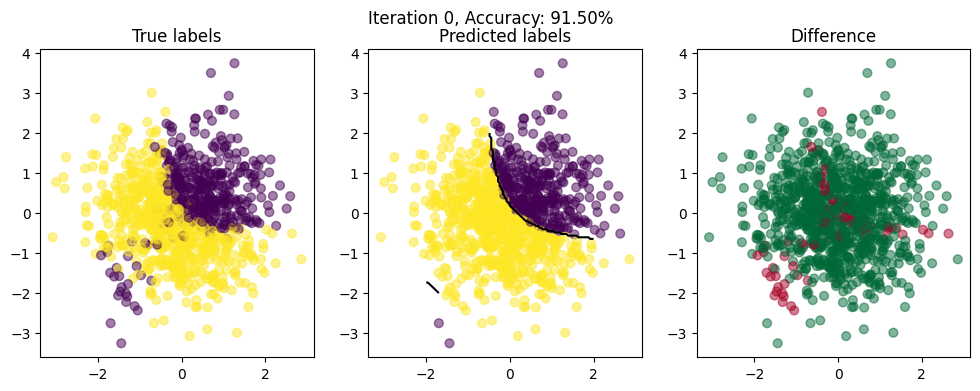

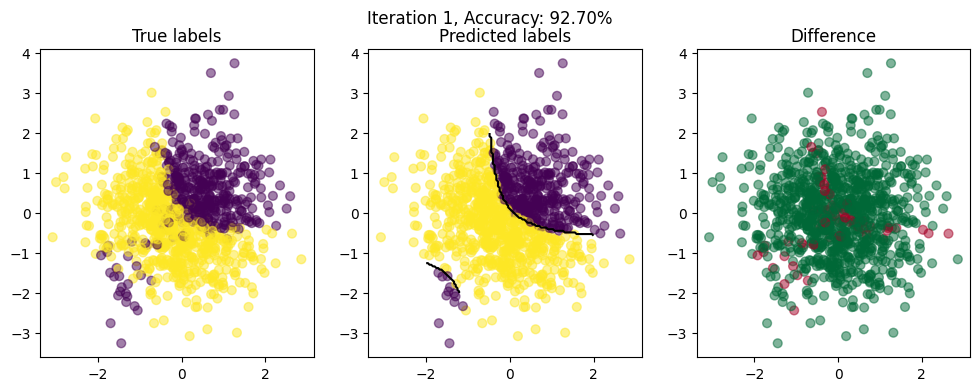

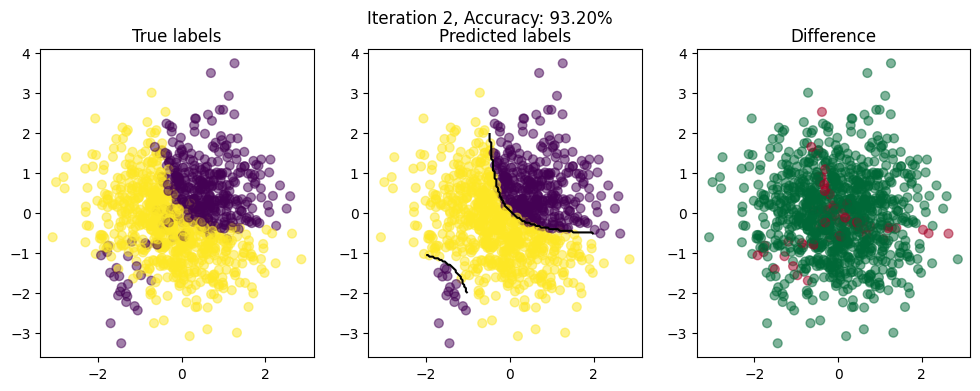

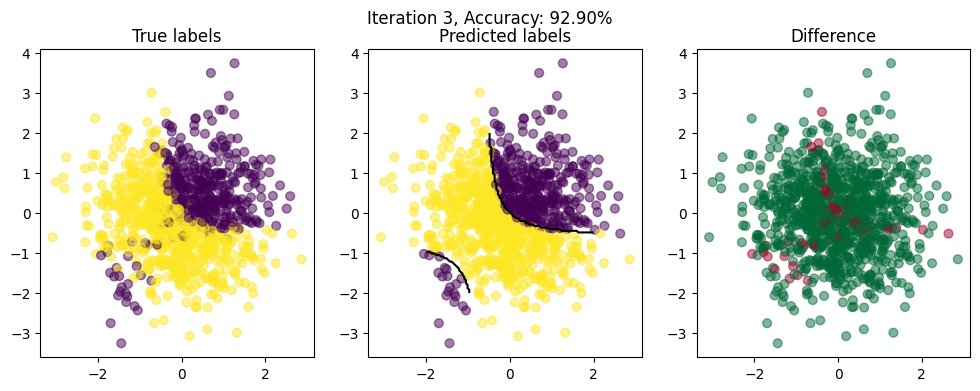

In [6]:
X, Y = generate_data(seed = 7, B = [0,1/3,1/3,1/2])
X.columns = ["X1","X2"]
lr_test = LR()
betas = lr_test.fit(X,Y, interactions=[[0,1]])

for i in range(len(betas)):
    lr_test.beta = betas[i]
    y_pred =  lr_test.predict(X)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    add_decision_boundary(ax, lr_test)
    ax[0].scatter(X['X1'], X['X2'], c=Y, alpha=0.5, s=40)
    ax[0].set_title('True labels')
    ax[1].scatter(X['X1'], X['X2'], c=y_pred, alpha=0.5, s=40)
    ax[1].set_title('Predicted labels')
    ax[2].scatter(X['X1'], X['X2'], c=-np.abs(y_pred-Y), cmap='RdYlGn', s=40, alpha=0.5)
    ax[2].set_title('Difference')
    accuracy = 1-np.mean(np.abs(y_pred-Y))
    fig.suptitle(f'Iteration {i}, Accuracy: {accuracy  :.2%}')    
    fig.savefig('training_iter_0.png', dpi=300, bbox_inches='tight')
    plt.show()
    

## Experiment 2 - Data without interactions

### Model without interactions

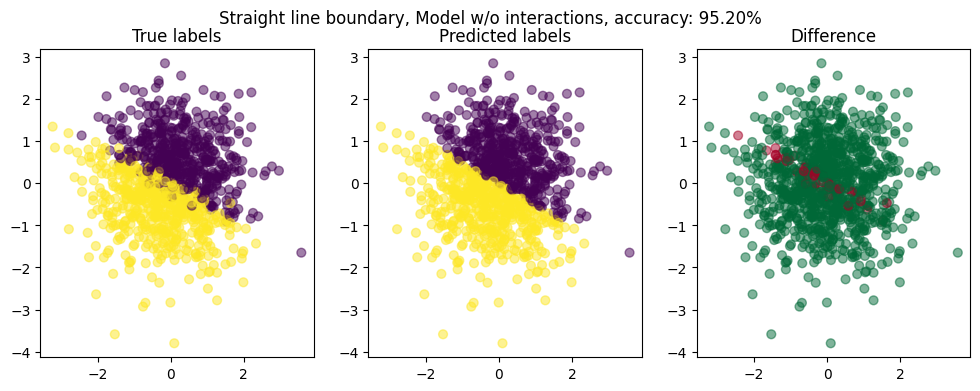

In [7]:
run_experiment(B=[0,1,2,0], title='Straight line boundary, Model w/o interactions', seed=123)

### Model with interactions

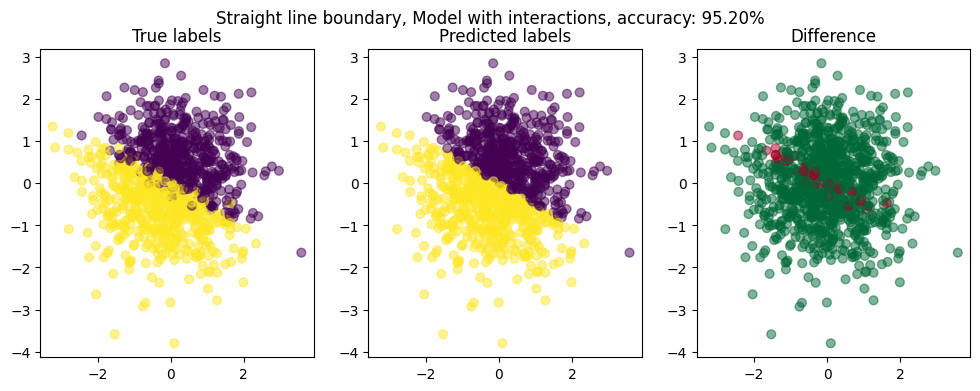

In [8]:
run_experiment(B=[0,1,2,0], interactions = True, title='Straight line boundary, Model with interactions', seed=123)

## Experiment 3 - Data with interactions

### Model without interactions

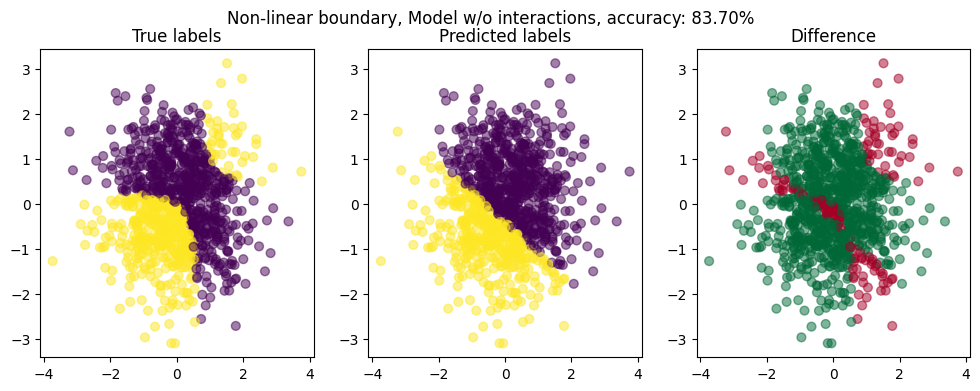

In [9]:
run_experiment(B=[0,1,2,-3], title='Non-linear boundary, Model w/o interactions', seed=234)

### Model with interactions

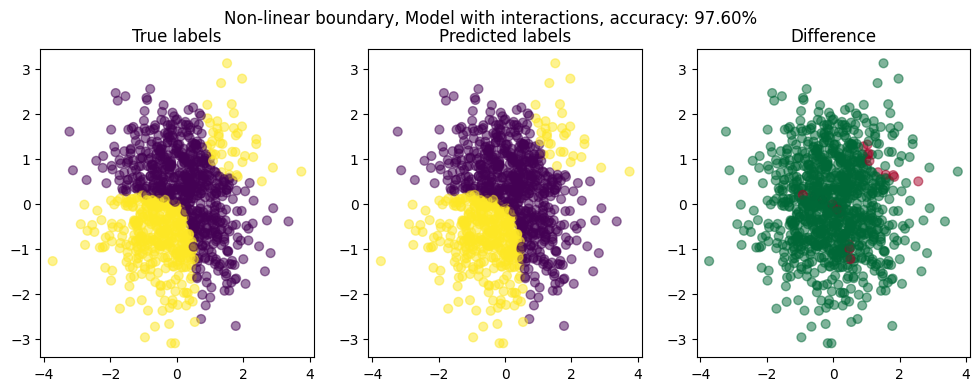

In [10]:
run_experiment(B=[0,1,2,-3], interactions = True, title='Non-linear boundary, Model with interactions', seed=234)

## Experiment 4 - XOR problem

### Model without interactions

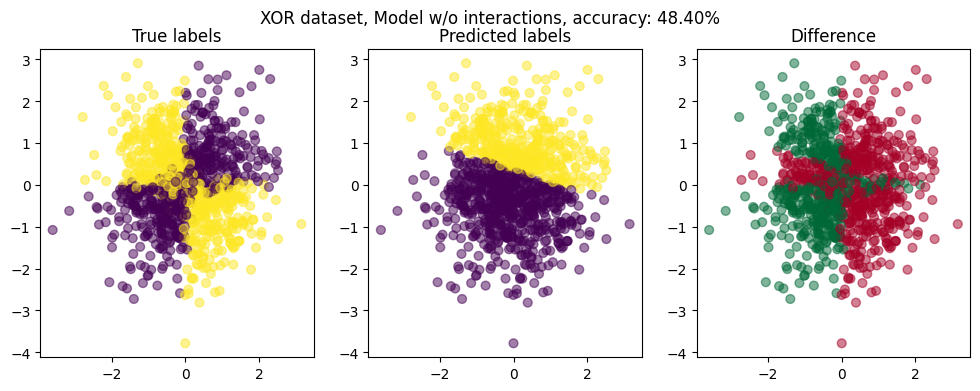

In [11]:
run_experiment(B=[0,0,0,1], title='XOR dataset, Model w/o interactions', seed=345)

### Model with interactions

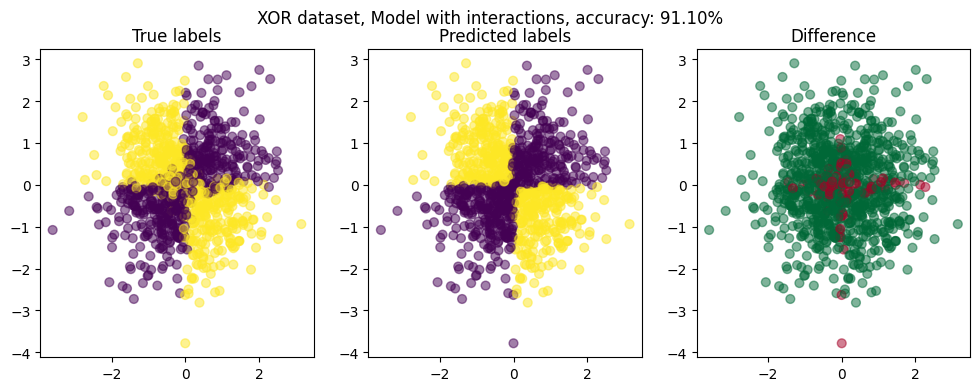

In [12]:
run_experiment(B=[0,0,0,1], interactions = True, title='XOR dataset, Model with interactions', seed=345)

## Experiment 5 - L2 regularization decreases betas

In [13]:
X, Y = generate_data([0,1,2,0], seed=456)

def get_experiment_results(X, Y, l2=0):
    lr = LR()
    lr.fit(X,Y, l2=l2)
    betas = lr.beta.flatten()
    result = np.array([betas[0], betas[1], betas[2], 1-np.mean(np.abs(lr.predict(X)-Y))])
    return result

unregularized = get_experiment_results(X,Y, l2=0)
regularized = get_experiment_results(X,Y, l2=10000)

results_df = pd.DataFrame(data=np.transpose([regularized.flatten(), unregularized.flatten()]), 
                          columns=['Regularized', 'Unregularized'], 
                          index=['Intercept', 'X1', 'X2', 'Accuracy'])
results_df

c:\Users\Maciek\Documents\Studia\semestr 8\AdvancedMachineLearning\project1-logistic regression\Logistic-Regression-with-IRLS\LogisticRegressionIRLS.py:49: ConvergenceWarning: Algorithm didn't converge! Iteration limit reached!
  warnings.warn("Algorithm didn't converge! Iteration limit reached!", ConvergenceWarning)


,Regularized,Unregularized
Intercept,0.058517,0.206766
X1,0.954011,5.608639
X2,1.945914,10.886756
Accuracy,0.958000,0.961000


## Simulation experiments results

Experiment results match the expectations:
1. Decision boundary is updated after each iteration. Accuracy increases at the beginning and then stabilises while decision boundaries move slightly around the optimal solution. 
2. Algorithm can learn a linearly separable dataset with close to 100% accuracy. 
3. Algorithm can learn a non-linearly separable dataset with close to 100% accuracy when interactions are included. Without them, the accuracy is lower, around 83%. The decision boundary is a straight line when interactions are not included (incorrect for this dataset, as expected), and a curved line when they are included.
4. Algorithm can learn XOR dataset with close to 100% accuracy when interactions are included. Without them, the accuracy is around 50%.
5. L2 regularization decreases betas with little effect on accuracy, as expected.
